In [1]:
import ROOT as r
import math
from BlindersPy3 import Blinders    #from the g-2 blinding software. 
                                    #Download link: https://cdcvs.fnal.gov/redmine/projects/gm2analyses/wiki/Library_installation
from BlindersPy3 import FitType

Welcome to JupyROOT 6.12/06


In [2]:
f = r.TFile("./gm2offline_ana_22530535_16119.00442.root")
f.ls()

TFile**		./gm2offline_ana_22530535_16119.00442.root	
 TFile*		./gm2offline_ana_22530535_16119.00442.root	
  KEY: TDirectoryFile	farline;1	farline (CaloFarlineHistograms) folder


In [3]:
t = f.Get("farline/eventTree")
t.Print()

******************************************************************************
*Tree    :eventTree : eventTree                                              *
*Entries :     2678 : Total =       523269178 bytes  File  Size =  392656273 *
*        :          : Tree compression factor =   1.33                       *
******************************************************************************
*Br    0 :runNum    : runNum/i                                               *
*Entries :     2678 : Total  Size=      12295 bytes  File Size  =       1540 *
*Baskets :       13 : Basket Size=      45334 bytes  Compression=   7.61     *
*............................................................................*
*Br    1 :subRunNum : subRunNum/i                                            *
*Entries :     2678 : Total  Size=      12346 bytes  File Size  =       1634 *
*Baskets :       13 : Basket Size=      45334 bytes  Compression=   7.20     *
*...................................................

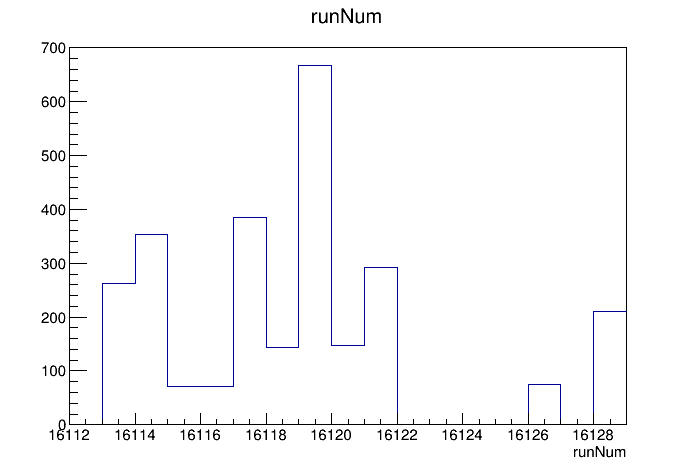

In [33]:
c = r.TCanvas()
t.Draw("runNum")
c.Draw()

### Lets first create our histogram and fill it with our wiggle

In [4]:
#lets first create a 2D energy vs. time distribution
h = r.TH2D("h","Wiggle Plot; Time [#mus]; Energy [MeV]", 4700,0,700, 600,0,6000)
t.Draw("energy:time*1.25/1000.>>h","energy < 6000","goff") #need to convert time from 'clock ticks' to microseconds using *1.25/1000.

14356944

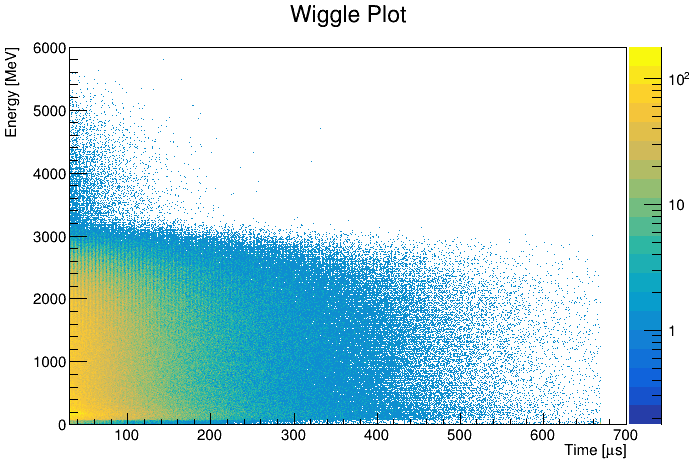

In [26]:
c = r.TCanvas()
h.Draw("colz")
h.GetXaxis().SetRangeUser(30,700)
c.SetLogz()
c.Draw()

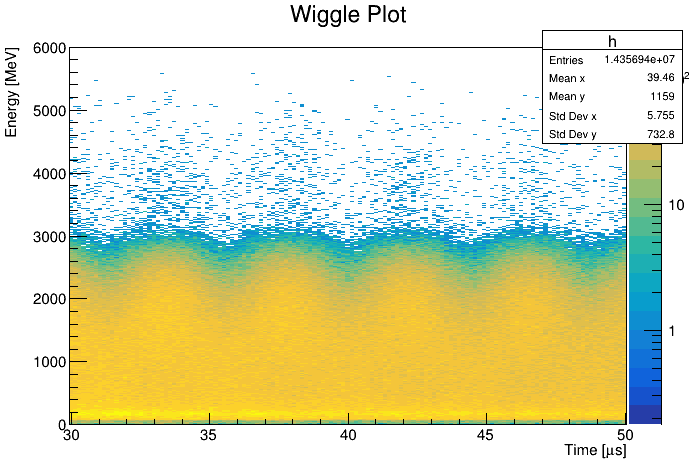

In [5]:
c = r.TCanvas()
h.Draw("colz")
h.GetXaxis().SetRangeUser(30,50)
c.SetLogz()
c.Draw()

In [6]:
#Now lets pick an energy value to start/end our wiggle from. We can play around with these values to see how it changes 
#    our result.
eLow = 1700 #MeV
eHigh = 6000 #Mev

#lets find the bins which correspond to those energy values
binLow = h.GetYaxis().FindBin(eLow)
binHigh = h.GetYaxis().FindBin(eHigh)
print(binLow, binHigh)

#now lets create a 1D histogram by projecting this histogram between those two bins
#https://root.cern.ch/doc/master/classTH2.html#a974ece9e7d260f92df00a39dba14e5b0
h.GetXaxis().SetRangeUser(0,700)
h2 = h.ProjectionX("_px", #the histogram is given the name of the original with this string appended to the end
                   binLow, binHigh # this is the range of bins that will be used for the projection. 
                  ).Clone("h2")
h2.GetYaxis().SetTitle("N / 148.9 ns")  #It's a good practice to label your bin widths on your plots. 
                                        #Just calculated by )700 microseconds)/(4700 bins)

171 601


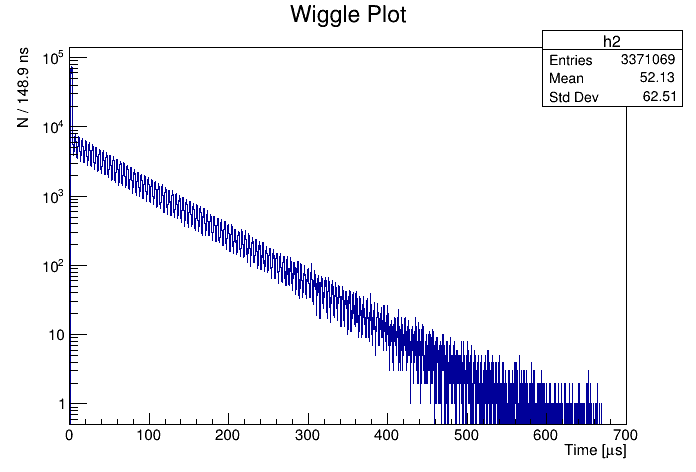

In [7]:
c = r.TCanvas()
h2.Draw("colz")
h2.GetXaxis().SetRangeUser(0,700)
c.SetLogy()
c.Draw()

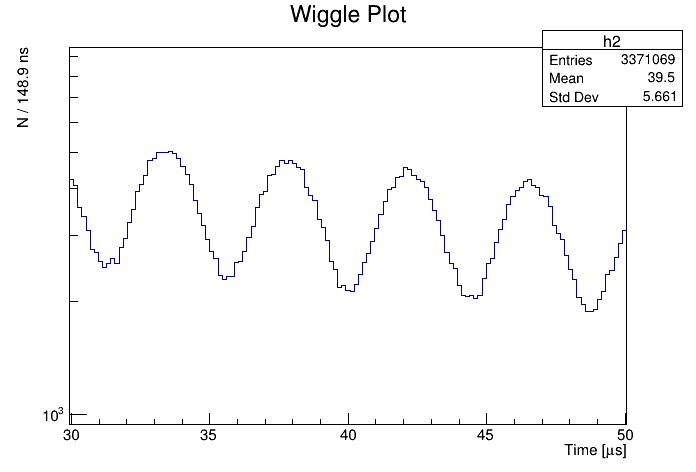

In [8]:
c = r.TCanvas()
h2.Draw("colz")
h2.GetXaxis().SetRangeUser(30,50)
c.SetLogy()
c.Draw()

## Now lets create the function in two ways.

### Entirely in ROOT:

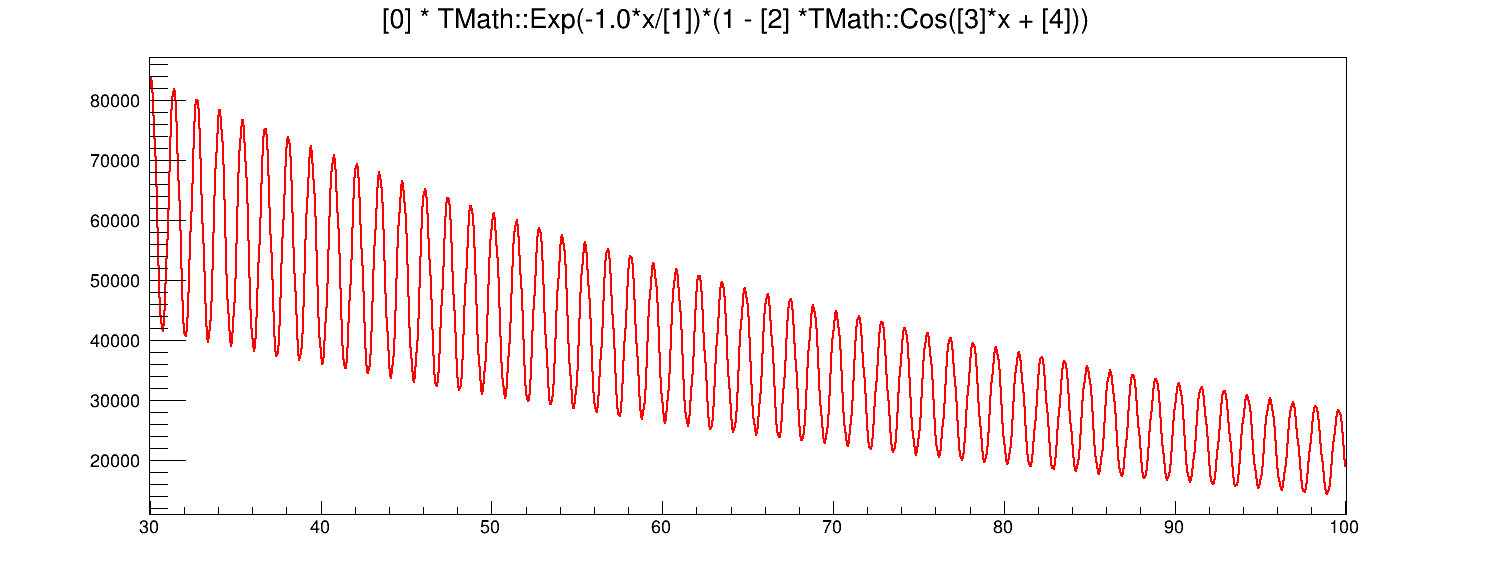

In [9]:
#THIS IS NOT BLINDED, DO NOT FIT WITH THIS ONE!!!!!
func = r.TF1("func", #the name given to the function
             "[0] * TMath::Exp(-1.0*x/[1])*(1 - [2] *TMath::Cos([3]*x + [4]))",  #the function itself. 
                                                                                 #Each of the [X] is a different fit parameter
             0, 700) #the range this function should be valid in
func.SetParameters(100000, 64.4, 0.333, 4.7, 0)
func.SetNpx(10000) #this makes sure we see all the detail when we draw it

c = r.TCanvas("c","c",1500,600)
func.Draw()
func.GetXaxis().SetRangeUser(30,100)
c.Draw()

### And in python:

In [27]:
'''
    This utility will implement the g-2 blinding software. This turns omega_a into a blinded R-value using a blinding phrase.
    With the phrase, the code generates a random +/- 100 ppm (part per million) offset from the 'known' value of omega_a, which
    we refer to as R. Then you fit using that R-parameter. This ensures that we don't bias our results by trying to tune values of
    omega_a to turn out the way we want.
'''
getBlinded = Blinders(FitType.Omega_a, #this tells the blinding class that we are using an omega_a fit
                      'Super secret blinding phrase. Everyones shouldfjknvekjvnekjd be unique!') #super secret blinding phrase

#and here is the pythonic function, which takes x (the variables to be fit against, in this case time) and p (the fit parameters)
def blinded_wiggle(x, p):
    norm  = p[0] #we choose to give them names to make it easier to define the function later on
    life  = p[1]
    asym  = p[2]
    R     = p[3]
    phi   = p[4]
    
    time  = x[0]
    omega = getBlinded.paramToFreq(R) #blinded version
    # omega = R #completely unblinded version
    
    return norm * math.exp(-time/life) * (1 - asym*math.cos(omega*time + phi))

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [28]:
#here we define the TF1function and give it some initial parameters. Then we can plot the function to see if our initial guess is good.
func2 = r.TF1("func2", #name to give the function
              blinded_wiggle, #which input function to use, in this case a python function of (x,p)
              30,600, #the lower and upper bound for this function
              5) #the number of parameters this function has.
func2.SetParNames('N','#tau','A','R( #omega_{a} )','#phi') #set the parameter names
func2.SetParameters(7000,64.4,0.4, 0, 5.2) #set initial parameter values
func2.SetLineColor(3) #give it a color (see TColor)
func2.SetNpx(10000) 

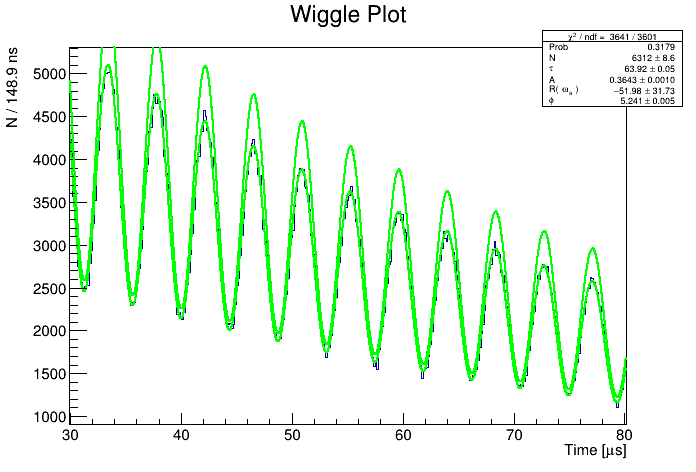

In [29]:
c = r.TCanvas()
h2.Draw()
h2.GetXaxis().SetRangeUser(30,80)
func2.Draw("SAME")
c.Draw()

---

### Now we can fit the histogram with one. Lets use the pythonic (blinded!) one

 FCN=3640.67 FROM MINOS     STATUS=SUCCESSFUL     36 CALLS         377 TOTAL
                     EDM=1.20488e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  N            6.31182e+03   8.62146e+00  -2.65104e-03  -3.62227e-08
   2  #tau         6.39196e+01   4.90682e-02  -9.47548e-06  -3.24435e-06
   3  A            3.64304e-01   1.02924e-03  -1.39801e-06   1.69659e-04
   4  R( #omega_{a} )  -7.87674e+01   3.17315e+01  -1.26432e-04  -8.56035e-08
   5  #phi         5.24106e+00   5.17868e-03   5.17868e-03   2.94192e-03


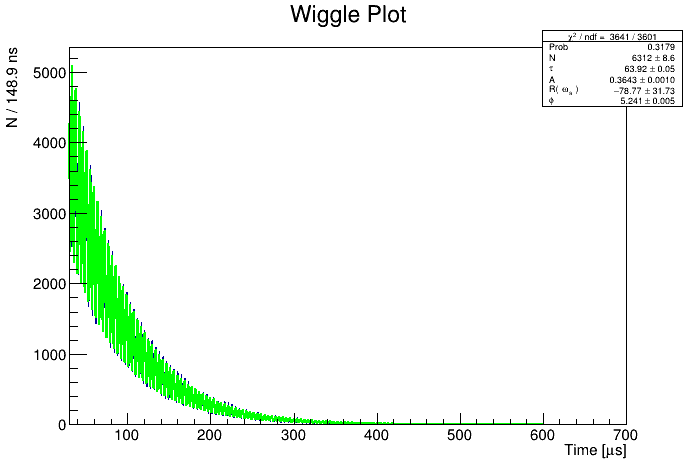

In [30]:
c = r.TCanvas()
r.gStyle.SetOptFit(1111)
r.gStyle.SetOptStat(0)
h2.Draw()
h2.GetXaxis().SetRangeUser(30,700)
h2.Fit("func2", #which function to fit with
     "REM")     #fit options. R = Fit only in the defined range for the function. 
                #    See: https://root.cern.ch/root/htmldoc/guides/users-guide/FittingHistograms.html#the-fit-method
c.Draw()

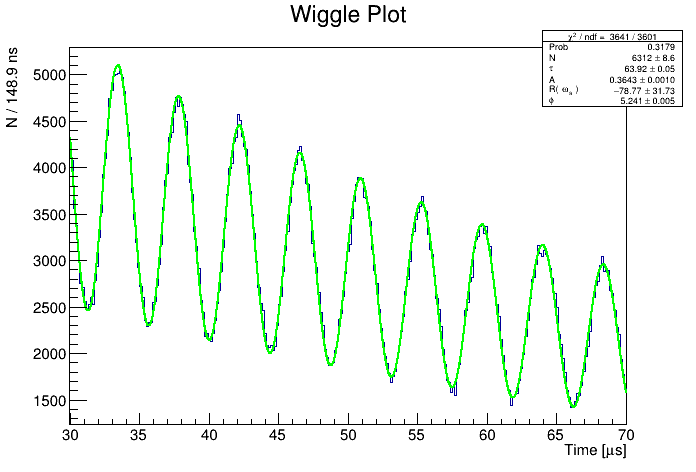

In [31]:
c = r.TCanvas()
h2.Draw()
h2.GetXaxis().SetRangeUser(30,70)
c.Draw()

In [15]:
### Now lets calculate the residuals and see if theres any structure there
h3 = h2.Clone("h3")
h3.SetTitle("Wiggle Plot Residuals: Bin - Fit")
h3.Reset()

residVec = []

for i in range(h2.GetNbinsX()):
    binCenter = h2.GetBinCenter(i)
    fitValue = func2.Eval(binCenter)
    content = h2.GetBinContent(i)
    if(binCenter > 20 and binCenter < 700):
        residVec.append( (binCenter, content-fitValue) )
    
    h3.SetBinContent(i, content - fitValue)

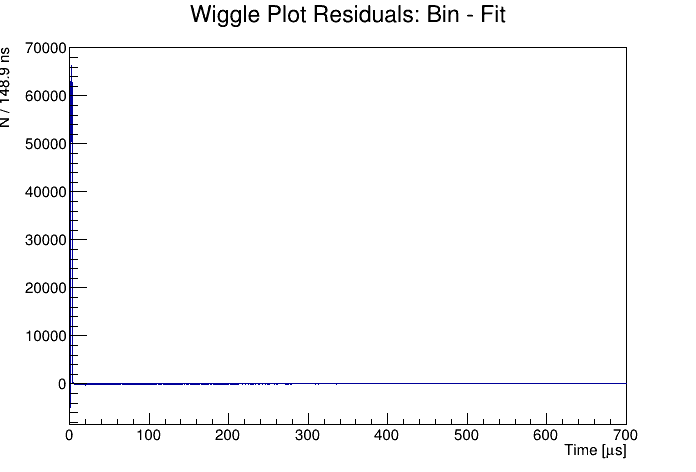

In [16]:
c = r.TCanvas()
h3.GetXaxis().SetRangeUser(0,700)
h3.Draw()
c.Draw()

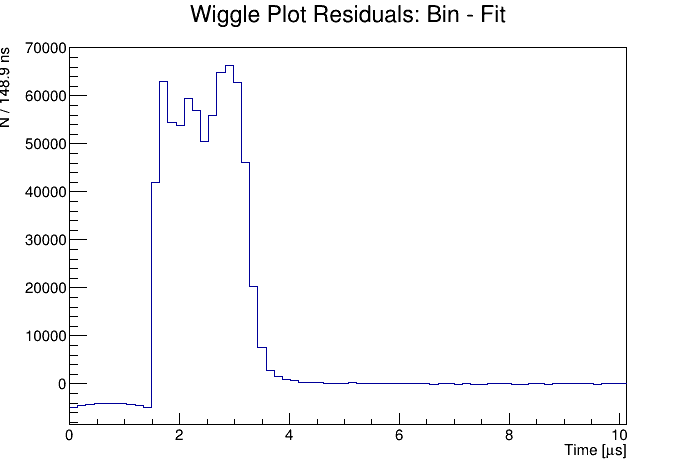

In [17]:
c = r.TCanvas()
h3.GetXaxis().SetRangeUser(0,10)
h3.Draw()
c.Draw()

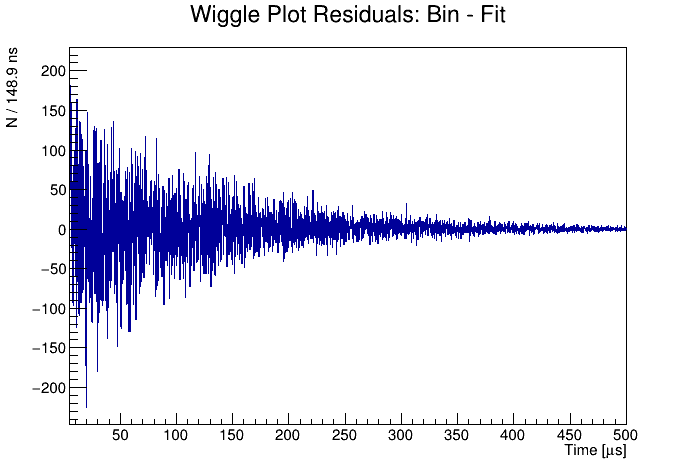

In [18]:
c = r.TCanvas()
h3.GetXaxis().SetRangeUser(5,500)
h3.Draw()
c.Draw()

### Is there any single frequency structure there? Maybe a FFT can reveal something

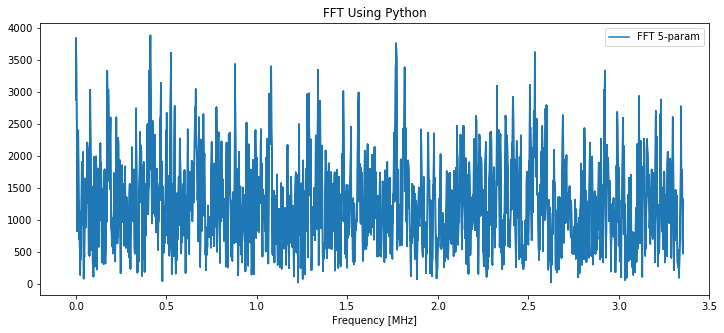

In [20]:
import numpy as np
import matplotlib.pyplot as plt

centers, bins = zip(*residVec)
ding = np.fft.fft(np.array(bins)) #perform a fourier transform using numpy on the bin contents.

n = len(bins)
d = (centers[1] - centers[0])*math.pow(10.0,-6) #go from microseconds to seconds

freq = np.fft.fftfreq(n, d) #convert this fourier series to sensible units

fig, ax = plt.subplots(figsize=(12, 5))
plt.plot(np.abs([x/(10**6) for x in freq]) #convert from Hz to MHz
         ,np.abs(ding)
         ,'-',label='FFT 5-param')
plt.title("FFT Using Python")
plt.xlabel("Frequency [MHz]")
plt.xlim(-0.2, 3.5)# *10.**6)
plt.legend()
plt.show()